# Analysis of size of control samples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [4]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_ctrl_size/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [5]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [9]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [213]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'PAC':pal[3], 'PC':pal[7], 'PA':pal[9], 'joint_PC':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [214]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette)
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette)
}

### Experiment set-up

```
outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/

for d in $(ls -d $outdir/qPBMC*/); do
    for n in $(seq 3 15); do
        for s in $(seq 12345 12347); do 
            python scripts/run_ctrl_size.py $d $n $s
        done
    done
done
```


### Parse results 

In [12]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

In [56]:
def _add_perturb_pop_info(pac_design_adata, perturb_pop, min_perturb_cells = 10):
    pac_design_adata.obs['is_perturb_pop'] = pac_design_adata.obs[population_obs] == perturb_pop
    perturb_nhoods = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0) > min_perturb_cells
    pac_design_adata.uns['nhood_adata'].obs['is_perturb_nhood'] = perturb_nhoods
    pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells'] = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0)
    pac_design_adata.uns['nhood_adata'].obs['n_cells'] = np.array(pac_design_adata.obsm['nhoods'].sum(0)).flatten()
    pac_design_adata.uns['nhood_adata'].obs['frac_perturb_cells'] = pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells']/pac_design_adata.uns['nhood_adata'].obs['n_cells']

def run_milo(adata_design, query_group, reference_group,
             sample_col= 'sample_id',
             annotation_col= 'cell_type',
             design = '~ is_query'
             ):
            milopy.core.make_nhoods(adata_design, prop=0.1)
            milopy.core.count_nhoods(adata_design, sample_col=sample_col)
            milopy.utils.annotate_nhoods(
                adata_design[adata_design.obs['dataset_group'] == reference_group], annotation_col)
            adata_design.obs['is_query'] = adata_design.obs['dataset_group'] == query_group
            milopy.core.DA_nhoods(adata_design, design=design)

In [17]:
dirs = [x for x in os.listdir(outdir) if not x.endswith('.h5ad') and x.startswith('qPBMC')]

In [150]:
d = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered//qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'

In [151]:
nhood_obs_all = pd.DataFrame()
for ctrl_d in os.listdir(d + '/ctrl_size_analysis/'):
    ctrl_sim_dir = d + '/ctrl_size_analysis/' + ctrl_d
    n_ctrls = int(ctrl_sim_dir.split("/")[-1].split('_')[1].strip('size'))
    sim_seed = int(ctrl_sim_dir.split("/")[-1].split('_')[-1].strip('seed'))

    perturb_pop = d.split('/')[-1].split('perturb_cell_type')[-1].split('_queryBatch')[0]
    pac_design_adata = sc.read_h5ad(ctrl_sim_dir + '/PAC_design.h5ad', backed=True)
    pac_design_adata.obs['dataset_group'] = np.where(pac_design_adata.obs['is_test'] == 1, 'query', 'ctrl')

    pc_design_adata = sc.read_h5ad(ctrl_sim_dir + '/PC_design.h5ad', backed=True)
    pc_design_adata.obs['dataset_group'] = np.where(pc_design_adata.obs['is_test'] == 1, 'query', 'ctrl')
    
    jpc_design_adata = sc.read_h5ad(ctrl_sim_dir + '/joint_PC_design.h5ad', backed=True)
    jpc_design_adata.obs['dataset_group'] = np.where(jpc_design_adata.obs['is_test'] == 1, 'query', 'ctrl')

    run_milo(pc_design_adata, query_group='query', reference_group='ctrl')
    _add_perturb_pop_info(pc_design_adata, perturb_pop)
    
    run_milo(jpc_design_adata, query_group='query', reference_group='ctrl')
    _add_perturb_pop_info(jpc_design_adata, perturb_pop)

    run_milo(pac_design_adata, query_group='query', reference_group='ctrl')
    _add_perturb_pop_info(pac_design_adata, perturb_pop)

    ## Store nhood info
    des_dict = {'PAC':pac_design_adata, "PC": pc_design_adata, 'joint_PC': jpc_design_adata}
    for design, adata in des_dict.items():
        nhood_obs = get_nhood_adata(adata).obs.copy()
        nhood_obs['design'] = design
        nhood_obs['perturb_pop'] = perturb_pop
        nhood_obs['n_ctrls'] = n_ctrls
        nhood_obs['random_seed'] = sim_seed
        nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/an

In [179]:
# for ctrl_d in os.listdir(d + '/ctrl_size_analysis/'):
#     ctrl_sim_dir = d + '/ctrl_size_analysis/' + ctrl_d
#     n_ctrls = int(ctrl_sim_dir.split("/")[-1].split('_')[1].strip('size'))
#     sim_seed = int(ctrl_sim_dir.split("/")[-1].split('_')[-1].strip('seed'))

#     perturb_pop = d.split('/')[-1].split('perturb_cell_type')[-1].split('_queryBatch')[0]
#     jpc_design_adata = sc.read_h5ad(ctrl_sim_dir + '/jointPC_design.h5ad', backed=True)
#     jpc_design_adata.obs['dataset_group'] = np.where(jpc_design_adata.obs['is_test'] == 1, 'query', 'ctrl')

#     run_milo(jpc_design_adata, query_group='query', reference_group='ctrl')
#     _add_perturb_pop_info(jpc_design_adata, perturb_pop)
    
#     ## Store nhood info
#     des_dict = {'joint_PC': jpc_design_adata}
#     for design, adata in des_dict.items():
#         nhood_obs = get_nhood_adata(adata).obs.copy()
#         nhood_obs['design'] = design
#         nhood_obs['perturb_pop'] = perturb_pop
#         nhood_obs['n_ctrls'] = n_ctrls
#         nhood_obs['random_seed'] = sim_seed
#         nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7

<AxesSubplot:xlabel='logFC', ylabel='frac_perturb_cells'>

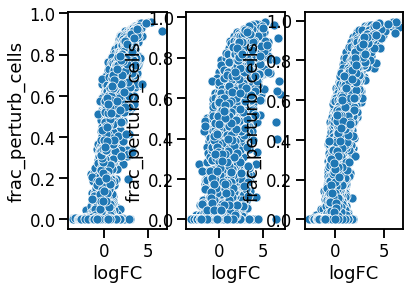

In [180]:
plt.subplot(1,3,1);
sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design == 'PAC'], x='logFC', y='frac_perturb_cells' );
plt.subplot(1,3,2);
sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design == 'PC'], x='logFC', y='frac_perturb_cells' )
plt.subplot(1,3,3);
sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design == 'joint_PC'], x='logFC', y='frac_perturb_cells' )

## Compute Area under precision-recall curve

In [181]:
from sklearn.metrics import auc, precision_recall_curve

def _compute_AUPRC(out_df):    
    precision, recall, _ = precision_recall_curve(out_df.is_perturb_nhood, out_df['logFC'])
    no_skill = sum(out_df.is_perturb_nhood) / out_df.shape[0]
    AUC = auc(recall, precision)
    AUPRC_df = pd.DataFrame(np.vstack([recall, precision]), index=['Recall','Precision']).T
    AUPRC_df['AUPRC'] = AUC
    AUPRC_df['no_skill_thresh'] = no_skill
    return(AUPRC_df)


In [182]:
nhood_obs_all['simulation_ID'] = nhood_obs_all.design + "_" + nhood_obs_all.perturb_pop + "_" + nhood_obs_all.n_ctrls.astype('str') + "_" + nhood_obs_all.random_seed.astype('str')

In [183]:
AUPRC_df_all = pd.DataFrame()
for s in nhood_obs_all['simulation_ID'].unique():
    nhood_obs = nhood_obs_all[nhood_obs_all['simulation_ID'] == s]
    AUPRC_df = _compute_AUPRC(nhood_obs)
    AUPRC_df['simulation_ID'] = s
    AUPRC_df['design'] = nhood_obs['design'][0]
    AUPRC_df['n_ctrl'] = nhood_obs['n_ctrls'][0]
    AUPRC_df_all = pd.concat([AUPRC_df_all, AUPRC_df])
AUPRC_df_all = AUPRC_df_all[['AUPRC', 'no_skill_thresh', 'simulation_ID', 'design', 'n_ctrl']].drop_duplicates()

In [184]:
%%R -i AUPRC_df_all
head(AUPRC_df_all)

      AUPRC no_skill_thresh
1 0.8662555       0.3592896
2 0.8579633       0.3759398
3 0.8475733       0.3448735
4 0.7880973       0.4319307
5 0.8662555       0.3592896
6 0.8579633       0.3759398
                                               simulation_ID design n_ctrl
1  PAC_central_memory_CD4_positive_alpha_beta_T_cell_9_12345    PAC      9
2   PC_central_memory_CD4_positive_alpha_beta_T_cell_9_12345     PC      9
3 PAC_central_memory_CD4_positive_alpha_beta_T_cell_11_12346    PAC     11
4  PC_central_memory_CD4_positive_alpha_beta_T_cell_11_12346     PC     11
5  PAC_central_memory_CD4_positive_alpha_beta_T_cell_8_12347    PAC      8
6   PC_central_memory_CD4_positive_alpha_beta_T_cell_8_12347     PC      8


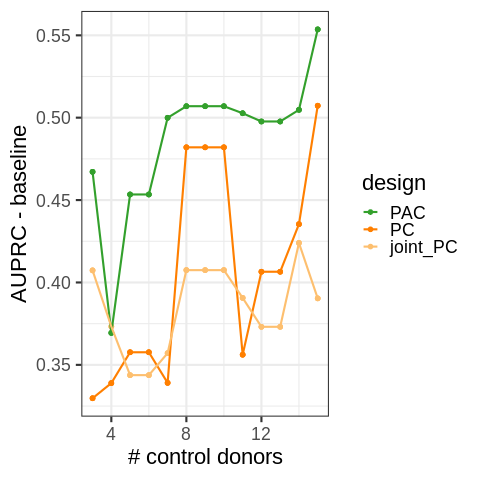

In [231]:
%%R
auprc_pl <- AUPRC_df_all %>%
    mutate(design = factor(design, levels=c('PAC', 'PC', 'joint_PC'))) %>%
    ggplot(aes(n_ctrl, AUPRC - no_skill_thresh, color=design)) +
    geom_point(size=2) +
    geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
    xlab('# control donors') +
    ylab('AUPRC - baseline')

auprc_pl

## Compute TPR/FPR

In [221]:
alpha = 0.1
nhood_obs_all['pred_positive'] = (nhood_obs_all.SpatialFDR < alpha) & (nhood_obs_all.logFC > 0)
nhood_obs_all['TP'] = nhood_obs_all['pred_positive'] & (nhood_obs_all['is_perturb_nhood']) & (nhood_obs_all.logFC > 0)
nhood_obs_all['FP'] = nhood_obs_all['pred_positive'] & (~nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['FN'] = (~nhood_obs_all['pred_positive']) & (nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['TN'] = (~nhood_obs_all['pred_positive']) & (~nhood_obs_all['is_perturb_nhood'])

In [222]:
tpr_df = nhood_obs_all.groupby(['design', 'perturb_pop', 'n_ctrls', 'simulation_ID']).sum()[['TP', 'FP', 'FN', "TN"]].reset_index()
tpr_df['TPR'] = tpr_df['TP'] / (tpr_df['TP'] + tpr_df['FN'])
tpr_df['FPR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TN'])
tpr_df['FDR'] = tpr_df['FP'] / (tpr_df['FP'] + tpr_df['TP'])
tpr_df['Precision'] = tpr_df['TP'] / (tpr_df['FP'] + tpr_df['TP'])
tpr_df['F1'] = ((tpr_df['Precision'] * tpr_df['TPR']) / (tpr_df['Precision'] + tpr_df['TPR'])) * 2
tpr_df.loc[tpr_df['FDR'].isna(), 'FDR'] = 0
tpr_df['design'] = tpr_df['design'].astype('category').cat.reorder_categories(['PAC', "PC", "joint_PC"])
tpr_df

,design,perturb_pop,n_ctrls,simulation_ID,TP,FP,FN,TN,TPR,FPR,FDR,Precision,F1
0,PAC,central_memory_CD4_positive_alpha_beta_T_cell,3,PAC_central_memory_CD4_positive_alpha_beta_T_c...,0,0,235,391,0.00000,0.0,0.0,NaN,NaN
1,PAC,central_memory_CD4_positive_alpha_beta_T_cell,3,PAC_central_memory_CD4_positive_alpha_beta_T_c...,0,0,235,391,0.00000,0.0,0.0,NaN,NaN
2,PAC,central_memory_CD4_positive_alpha_beta_T_cell,3,PAC_central_memory_CD4_positive_alpha_beta_T_c...,0,0,235,391,0.00000,0.0,0.0,NaN,NaN
3,PAC,central_memory_CD4_positive_alpha_beta_T_cell,4,PAC_central_memory_CD4_positive_alpha_beta_T_c...,0,0,261,397,0.00000,0.0,0.0,NaN,NaN
4,PAC,central_memory_CD4_positive_alpha_beta_T_cell,4,PAC_central_memory_CD4_positive_alpha_beta_T_c...,0,0,261,397,0.00000,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,joint_PC,central_memory_CD4_positive_alpha_beta_T_cell,14,joint_PC_central_memory_CD4_positive_alpha_bet...,71,0,265,567,0.21131,0.0,0.0,1.0,0.348894
113,joint_PC,central_memory_CD4_positive_alpha_beta_T_cell,14,joint_PC_central_memory_CD4_positive_alpha_bet...,71,0,265,567,0.21131,0.0,0.0,1.0,0.348894
114,joint_PC,central_memory_CD4_positive_alpha_beta_T_cell,15,joint_PC_central_memory_CD4_positive_alpha_bet...,74,0,253,577,0.22630,0.0,0.0,1.0,0.369077
115,joint_PC,central_memory_CD4_positive_alpha_beta_T_cell,15,joint_PC_central_memory_CD4_positive_alpha_bet...,74,0,253,577,0.22630,0.0,0.0,1.0,0.369077


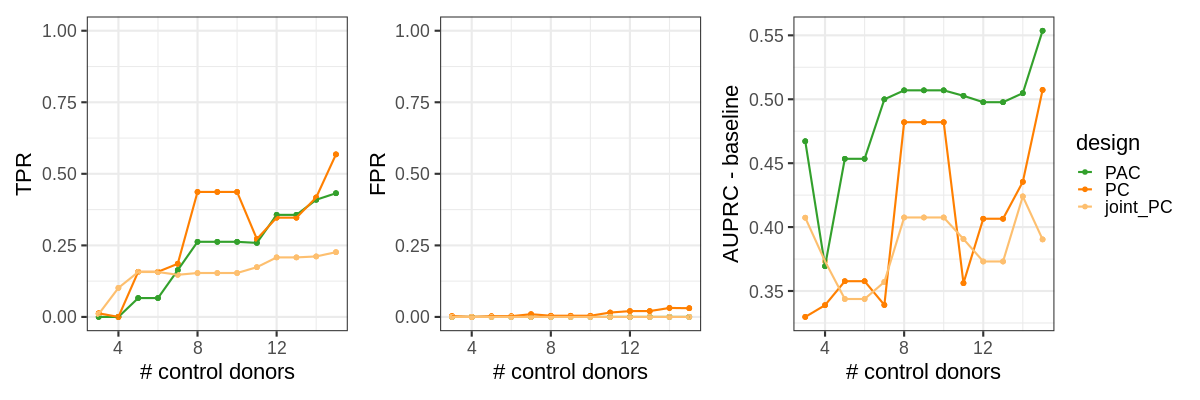

In [236]:
%%R -i tpr_df -w 1200 -h 400
tpr_pl <- tpr_df %>%
ggplot(aes(n_ctrls, TPR, color=design)) +
    geom_point(size=2) +
    geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
    ylim(0,1) +
    xlab('# control donors') 

fpr_pl <- tpr_df %>%
    ggplot(aes(n_ctrls, FPR, color=design)) +
    geom_point(size=2) +
    geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
    ylim(0,1) +
    xlab('# control donors') 
    
(tpr_pl + fpr_pl + auprc_pl) +
plot_layout(guides='collect')